In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import torchtext
import torchdata
import keras
import tensorflow

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

/Users/maksimkuznetsov/Documents/Учёба/w2v/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from tensorflow.keras.datasets import imdb

In [3]:
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)

# Получение словаря слов
word_index = imdb.get_word_index()

(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data()

word_index = imdb.get_word_index()

start_char = 1
oov_char = 2
index_from = 3

inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)

inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"

train_set = np.array([" ".join(inverted_word_index[i] for i in item) for item in training_data])
test_set = np.array([" ".join(inverted_word_index[i] for i in item) for item in testing_data])
                     
print(train_set.shape, test_set.shape)

(25000,) (25000,)


In [4]:
train_set

array(["[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksimkuznetsov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maksimkuznetsov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maksimkuznetsov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/maksimkuznetsov/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(token) for token in text)
    text = list(word for word in text if word not in stopwords)
    return ' '.join(text)
train_set_prepor = [preprocess_text(seq) for seq in train_set]
test_set_prepor = [preprocess_text(seq) for seq in test_set]

In [7]:
train_set_prepor[100]

'start great fan david lynch everything made dvd except hotel room hour twin peak movie found immediately grabbed bunch crudely drawn black white cartoon loud foul mouthed unfunny maybe know good maybe bunch crap wa foisted public name david lynch make buck let make clear care foul language part keep adjusting sound neighbor might highly disappointing release may well left deluxe box set curiosity highly recommend spend money'

Напишем baseline с log_reg для дальнейшего сравнения 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [9]:
tf_idf = TfidfVectorizer().fit(train_set_prepor)
train_baseline = tf_idf.fit_transform(train_set_prepor)
test_baseline = tf_idf.transform(test_set_prepor)

In [10]:
log_reg = LogisticRegression(n_jobs=-1).fit(train_baseline, training_targets)

In [11]:
print('Train acc: ', accuracy_score(training_targets, log_reg.predict(train_baseline)))
print('Test acc: ', accuracy_score(testing_targets, log_reg.predict(test_baseline)))

Train acc:  0.93084
Test acc:  0.88048


In [12]:
from torchtext.vocab import build_vocab_from_iterator
def dataset_it(text):
    for parts in text:
        yield parts.split()
vocab = build_vocab_from_iterator(dataset_it(train_set), specials = ['<pad>', '<unk>'], min_freq = 10)


/Users/maksimkuznetsov/Documents/Учёба/w2v/.venv/lib/python3.9/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/maksimkuznetsov/Documents/Учёба/w2v/.venv/lib/python3.9/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [13]:
train_tokens = []
for text in dataset_it(train_set):
    tokens = [vocab[word] if word in vocab else vocab['<unk>'] for word in text]
    train_tokens += [tokens]

test_tokens = []
for text in dataset_it(test_set):
    tokens = [vocab[word] if word in vocab else vocab['<unk>'] for word in text]
    test_tokens += [tokens]

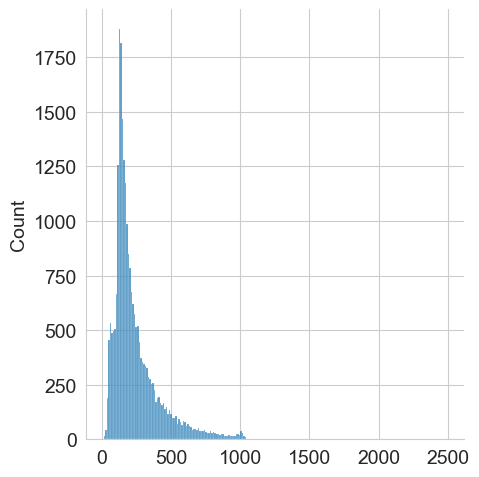

In [14]:
size = np.array([len(parts) for parts in train_tokens])
sns.displot(size)
plt.show()

In [53]:
max_len = 256
train_tokens_tensor = torch.full((len(train_tokens), max_len), vocab['<pad>'], dtype=torch.int32)
for i, tokens in enumerate(train_tokens_tensor):
    length = min(max_len, len(tokens))
    train_tokens_tensor[i, :length] = torch.tensor(tokens[:length])
    
test_tokens_tensor = torch.full((len(test_tokens), max_len), vocab['<pad>'], dtype=torch.int32)
for i, tokens in enumerate(test_tokens_tensor):
    length = min(max_len, len(tokens))
    test_tokens_tensor[i, :length] = torch.tensor(tokens[:length])

/var/folders/th/qmhb2jks46j3dlyv_krx10ww0000gn/T/ipykernel_89869/3773454868.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tokens_tensor[i, :length] = torch.tensor(tokens[:length])
/var/folders/th/qmhb2jks46j3dlyv_krx10ww0000gn/T/ipykernel_89869/3773454868.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tokens_tensor[i, :length] = torch.tensor(tokens[:length])


In [16]:
training_targets_tensor = torch.tensor(training_targets, dtype=torch.int32)
test_targets_tensor = torch.tensor(testing_targets, dtype=torch.int32)

In [54]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_tokens_tensor, training_targets_tensor)
test_dataset = TensorDataset(test_tokens_tensor, test_targets_tensor)
print(testing_targets)
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

[0 1 1 ... 0 0 0]


Теперь архитектура

In [18]:
import torch.nn as nn
import math

class PositionalEncoder(nn.Module):
    def __init__(self, max_len, embedding_dim, dropout):
        super().__init__()
        self.pos_features = torch.zeros((max_len, embedding_dim))
        positions = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        freqs = torch.exp(torch.arange(0, embedding_dim, 2, dtype=torch.float) * \
                          (-math.log(10000) / embedding_dim)).unsqueeze(0)
        args = positions * freqs
        self.pos_features[:, 0::2] = torch.sin(args)
        self.pos_features[:, 1::2] = torch.cos(args)
        self.pos_features = self.pos_features.unsqueeze(1)
        self.pos_features = nn.Parameter(self.pos_features, requires_grad=False)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        outputs = x + self.pos_features[:, :x.shape[1]]
        return self.dropout(outputs)
        

In [19]:
class Attention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super().__init__()
        attention_dim = embedding_dim // num_heads
        
        self.WQ = nn.Linear(embedding_dim, attention_dim, bias=False)
        self.WK = nn.Linear(embedding_dim, attention_dim, bias=False)
        self.WV = nn.Linear(embedding_dim, attention_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, keys, value, mask=None):
        Q = self.WQ(query)
        K = self.WK(keys)
        V = self.WV(value)
        
        norm_factor = math.sqrt(Q.shape[-1]) # Для корректной работы softmax
        dot_products = torch.bmm(Q, K.transpose(1, 2)) / norm_factor # Для каждого батча

        if mask is not None: # Маскируем если надо для декодера
            dot_products = dot_products.masked_fill(mask, -math.inf)

        attention_score = nn.functional.softmax(dot_products, dim=-1) # Считаем значимость остальных эмбеддов для данного
        attention = torch.bmm(self.dropout(attention_score), V) # Создаём более информативные эмбедды

        return attention, attention_score 

In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()
        
        assert embedding_dim % num_heads == 0 # Проверка для выхода
        self.attention_heads = nn.ModuleList([Attention(embedding_dim, num_heads, dropout) for _ in range(num_heads)])

        self.linear = nn.Linear(embedding_dim, embedding_dim, bias=False) # forward слой
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        attentions, attention_scores = [], []

        for head in self.attention_heads: # Копим скоры
            attention, attention_score = head(query, key, value, mask)
            attentions += [attention]
            attention_scores += [attention_score]
        # Складываем результаты
        attentions = torch.cat(attentions, dim=-1)
        attention_scores = torch.stack(attention_scores, dim=-1)

        outputs = self.linear(attentions)
        outputs = self.dropout(outputs)

        return outputs, attention_scores

In [21]:
def create_padding_mask(tokens, pad_idx=vocab['<pad>']):
    length = tokens.shape[-1]
    padding_mask = (tokens == pad_idx)
    padding_mask = padding_mask.unsqueeze(1).repeat(1, length, 1)

    return padding_mask

In [22]:
class TransformerLayer(nn.Module):
    def __init__(self, embed_dim, fc_dim, num_heads, dropout):
        super().__init__()
        self.self_attention = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, inputs, mask):
        attention, attention_score = self.self_attention(query=inputs, key=inputs, 
                                                         value=inputs, mask=mask)
        outputs = inputs + attention
        outputs = self.norm1(outputs)
        outputs = outputs + self.feedforward(outputs)
        outputs = self.norm2(outputs)
        return outputs, attention_score
    
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_length, num_classes,
                 embed_dim, fc_dim, num_heads, num_layers, dropout):
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoder(max_length, embed_dim, dropout)
        self.layers = nn.ModuleList([TransformerLayer(embed_dim, fc_dim, num_heads, dropout) \
                                     for _ in range(num_layers)])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, tokens):
        embeds = self.embedding(tokens) * math.sqrt(self.embed_dim)
        outputs = self.pos_encoder(embeds)

        padding_mask = create_padding_mask(tokens)
        attention_scores = []
        for layer in self.layers:
            outputs, attention_score = layer(outputs, padding_mask)
            attention_scores += [attention_score]
        attention_scores = torch.stack(attention_scores, dim=-1)

        mask = (tokens != vocab['<pad>']).to(torch.float).detach()
        lengths = mask.sum(dim=1).detach()
        outputs = (outputs * mask.unsqueeze(2)).sum(dim=1) / lengths.unsqueeze(1)

        logits = self.classifier(outputs)

        return logits, attention_scores

In [23]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Transformer(vocab_size=len(vocab), max_length=max_len, num_classes=1,
                    embed_dim=64, fc_dim=64, num_heads=4, num_layers=4, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
     

Training 1/20:   0%|          | 0/97 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/97 [00:00<?, ?it/s]

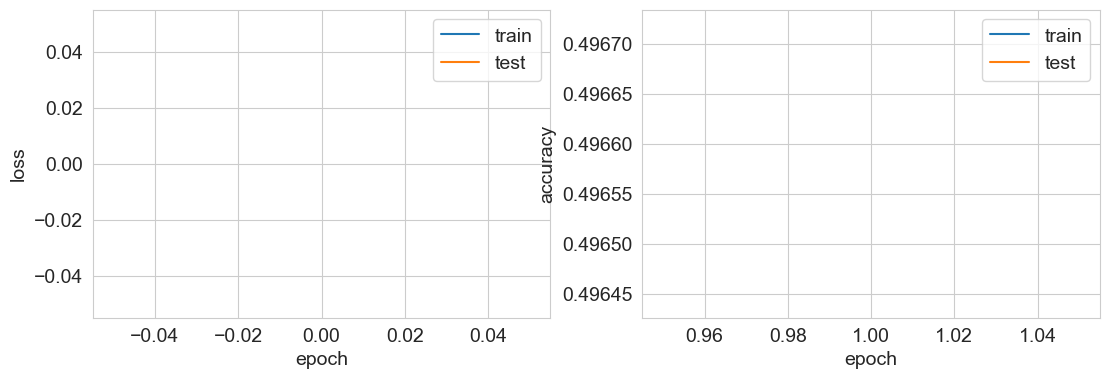

Training 2/20:   0%|          | 0/97 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/97 [00:00<?, ?it/s]

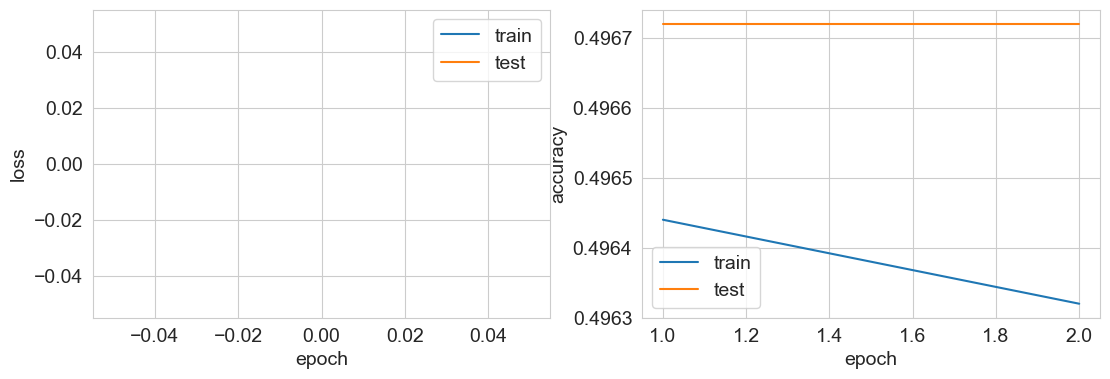

Training 3/20:   0%|          | 0/97 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/97 [00:00<?, ?it/s]

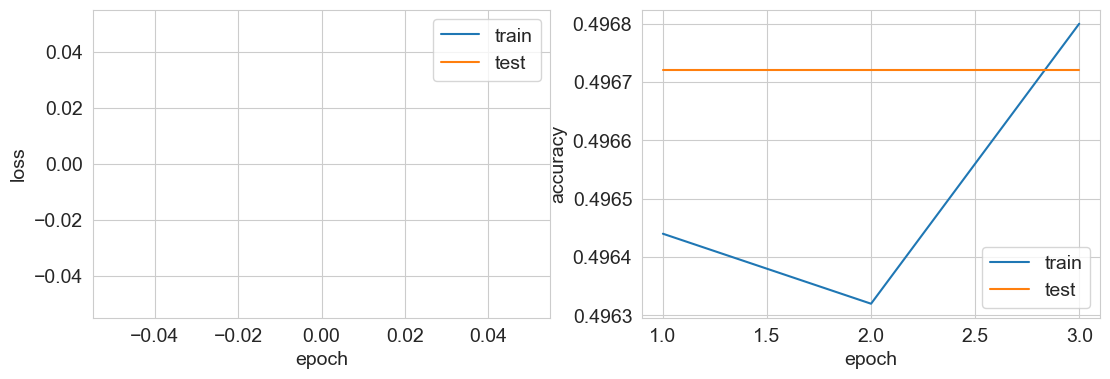

Training 4/20:   0%|          | 0/97 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/97 [00:00<?, ?it/s]

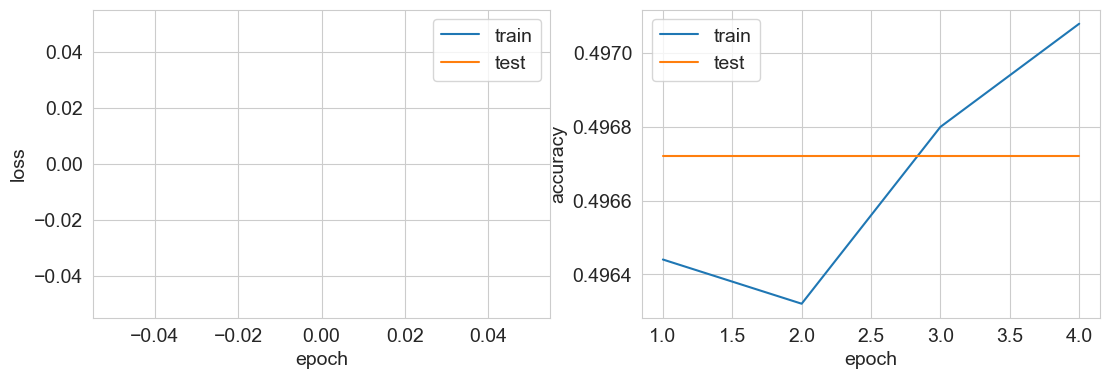

Training 5/20:   0%|          | 0/97 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [56]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, running_accuracy = 0.0, 0.0
    for tokens, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        tokens = tokens.to(device)
        labels = labels.to(device)
        logits, _ = model(tokens)
        probs = torch.sigmoid(logits.squeeze(1))
        loss = criterion(logits.squeeze(1), labels.to(torch.float))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * tokens.shape[0]
        running_accuracy += ((probs > 0.5).to(torch.int) == labels).sum().item()
        
    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    model.eval()
    running_loss, running_accuracy = 0.0, 0.0
    for tokens, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        tokens = tokens.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits, _ = model(tokens)
            probs = torch.sigmoid(logits.squeeze(1))
            loss = criterion(logits.squeeze(1), labels.to(torch.float))
        
        running_loss += loss.item() * tokens.shape[0]
        running_accuracy += ((probs > 0.5).to(torch.int) == labels).sum().item()
        
    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')